In [3]:
import pandas as pd
import numpy as np
import os
import gc
import warnings
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

parquet_files = [f'/content/{f}' for f in os.listdir('/content') if f.startswith('part-') and f.endswith('.snappy.parquet')]
df_combined = pd.concat([pd.read_parquet(file) for file in parquet_files], ignore_index=True)
df_combined.to_parquet('/content/sales_All_data_final_grouped.parquet', index=False)

In [4]:
df = dd.read_parquet('/content/sales_All_data_final_grouped.parquet', engine="pyarrow")

In [5]:
df['year'] = df['date'].dt.year.astype('int16')
df['month'] = df['date'].dt.month.astype('int8')
df['day'] = df['date'].dt.day.astype('int8')
df['dayofweek'] = df['date'].dt.dayofweek.astype('int8')
df['quarter'] = df['date'].dt.quarter.astype('int8')
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6])
df['days_in_month'] = df['date'].dt.days_in_month.astype('int8')
df['day_of_year'] = df['date'].dt.dayofyear.astype('int16')
df['week_of_year'] = df['date'].dt.isocalendar().week.astype('int8')

In [6]:
df = df.compute()
gc.collect()

48

In [7]:
def count_outliers_iqr(df):
    outlier_counts = {}
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_counts[col] = outliers
    return pd.Series(outlier_counts).sort_values(ascending=False)

In [8]:
outlier_summary = count_outliers_iqr(df)
print(outlier_summary)

unit_sales       278422
transactions     274700
oil_price        192508
precipitation    109064
temperature       32161
store_nbr             0
dtype: int64


In [9]:
df = df.astype({
    'store_nbr': 'int8',
    'onpromotion': 'bool',
    'perishable': 'bool',
    'transactions': 'float32',
    'oil_price': 'float32',
    'temperature': 'float32',
    'precipitation': 'float32',
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'dayofweek': 'int8',
    'quarter': 'int8',
    'is_weekend': 'bool',
    'days_in_month': 'int8',
    'day_of_year': 'int16',
    'week_of_year': 'int8'
}, errors='ignore')

In [10]:
categorical_cols = df.select_dtypes(include=['object', 'category', 'string[pyarrow]', 'bool']).columns.tolist()

In [11]:
print(df['Event Scale'].value_counts())
print(df['locale_name'].value_counts())

Event Scale
Non         1760124
National     160542
Local        122698
Regional      18539
Name: count, dtype: int64[pyarrow]
locale_name
Non                               1760124
Ecuador                            160542
Riobamba                            12024
Guayaquil                           11560
Guaranda                            11118
Quito                               10308
Ambato                               9727
El Carmen                            6534
Cayambe                              6470
Manta                                6218
Esmeraldas                           6148
Latacunga                            5904
Puyo                                 5856
Cotopaxi                             5846
Cuenca                               5826
Libertad                             5780
Santo Domingo de los Tsachilas       5127
Santa Elena                          5127
Loja                                 5099
Ibarra                               5003
Quevedo              

In [12]:
for col in categorical_cols:
    if df[col].nunique() <= 10:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True, dtype='bool')
        df = pd.concat([df.drop(columns=col), dummies], axis=1)
    else:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        df[col] = df[col].astype('int8')

In [13]:
df.head()

,date,store_nbr,family,unit_sales,city,state,transactions,oil_price,locale_name,temperature,precipitation,year,month,day,dayofweek,quarter,days_in_month,day_of_year,week_of_year,onpromotion_True,store_type_B,store_type_C,store_type_D,store_type_E,perishable_True,day_type_Bridge,day_type_Event,day_type_Holiday,day_type_Transfer,day_type_Work Day,Event Scale_National,Event Scale_Non,Event Scale_Regional,is_weekend_True
0,2016-02-18,27,0,6.00,4,6,7030.00,30.77,16,26.30,11.80,2016,2,18,3,1,29,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
1,2016-02-18,27,25,194.00,4,6,94202.00,30.77,16,26.30,11.80,2016,2,18,3,1,29,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
2,2016-02-18,27,15,10.00,4,6,8436.00,30.77,16,26.30,11.80,2016,2,18,3,1,29,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
3,2016-02-18,27,2,3.00,4,6,2812.00,30.77,16,26.30,11.80,2016,2,18,3,1,29,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
4,2016-02-18,27,18,160.00,4,6,67488.00,30.77,16,26.30,11.80,2016,2,18,3,1,29,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False


In [14]:
df = df.drop(columns='date')

In [15]:
from scipy.stats import skew
numeric_cols = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).columns.tolist()
for col in numeric_cols:
    if col == 'unit_sales':
        continue
    skewness = df[col].skew()
    if abs(skewness) > 1:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)

In [16]:
df.head()

,store_nbr,family,unit_sales,city,state,transactions,oil_price,locale_name,temperature,precipitation,year,month,day,dayofweek,quarter,days_in_month,day_of_year,week_of_year,onpromotion_True,store_type_B,store_type_C,store_type_D,store_type_E,perishable_True,day_type_Bridge,day_type_Event,day_type_Holiday,day_type_Transfer,day_type_Work Day,Event Scale_National,Event Scale_Non,Event Scale_Regional,is_weekend_True
0,27,0,6.00,4,6,7030.00,30.77,16,26.30,11.80,2016,2,18,3,1,29.00,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
1,27,25,194.00,4,6,94202.00,30.77,16,26.30,11.80,2016,2,18,3,1,29.00,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
2,27,15,10.00,4,6,8436.00,30.77,16,26.30,11.80,2016,2,18,3,1,29.00,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
3,27,2,3.00,4,6,2812.00,30.77,16,26.30,11.80,2016,2,18,3,1,29.00,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
4,27,18,160.00,4,6,67488.00,30.77,16,26.30,11.80,2016,2,18,3,1,29.00,49,7,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False


In [17]:
y = df['unit_sales']
X = df.drop(columns=['unit_sales'])

In [18]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [19]:
X_train.to_parquet('/content/X_train_processed.parquet', engine='pyarrow', index=False)
X_val.to_parquet('/content/X_val_processed.parquet', engine='pyarrow', index=False)
X_test.to_parquet('/content/X_test_processed.parquet', engine='pyarrow', index=False)

pd.DataFrame(y_train, columns=['unit_sales']).to_parquet('/content/y_train_processed.parquet', engine='pyarrow', index=False)
pd.DataFrame(y_val, columns=['unit_sales']).to_parquet('/content/y_val_processed.parquet', engine='pyarrow', index=False)
pd.DataFrame(y_test, columns=['unit_sales']).to_parquet('/content/y_test_processed.parquet', engine='pyarrow', index=False)

In [20]:
X_train = pd.read_parquet('/content/X_train_processed.parquet')
X_val = pd.read_parquet('/content/X_val_processed.parquet')
X_test = pd.read_parquet('/content/X_test_processed.parquet')

y_train = pd.read_parquet('/content/y_train_processed.parquet')['unit_sales']
y_val = pd.read_parquet('/content/y_val_processed.parquet')['unit_sales']
y_test = pd.read_parquet('/content/y_test_processed.parquet')['unit_sales']

In [21]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1237141, 32)
y_train: (1237141,)
X_val: (412381, 32)
y_val: (412381,)
X_test: (412381, 32)
y_test: (412381,)


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [23]:
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_val)
    inference_time = time.time() - start_time

    mse = mean_squared_error(y_val, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"\n{model_name} Evaluation on Validation Set:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Inference Time: {inference_time:.2f} seconds")

    return {
        'model': model,
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'train_time': train_time,
        'inference_time': inference_time,
        'y_pred': y_pred
    }

In [24]:
model_results = {}

In [25]:
gc.collect()

247

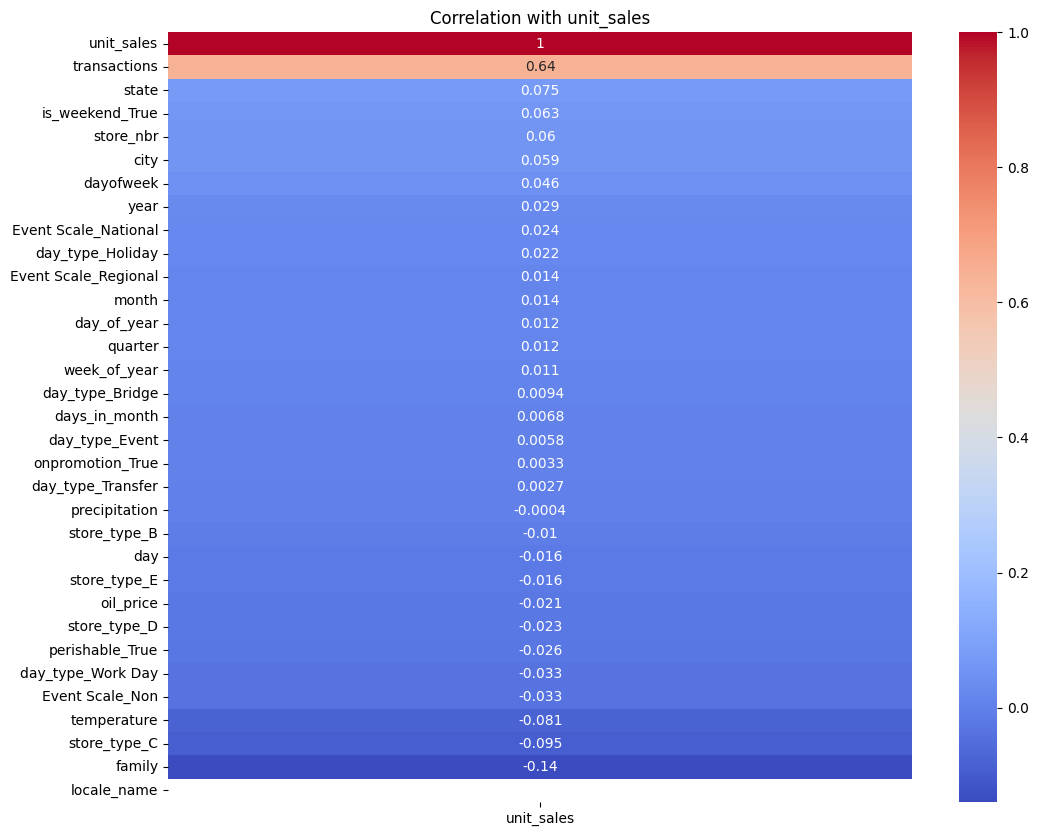

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = X_train.copy()
correlations['unit_sales'] = y_train
corr_matrix = correlations.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['unit_sales']].sort_values(by='unit_sales', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with unit_sales')
plt.show()

In [27]:
print(X_train.dtypes)

store_nbr                  int8
family                     int8
city                       int8
state                      int8
transactions            float32
oil_price               float32
locale_name                int8
temperature             float32
precipitation           float64
year                      int16
month                      int8
day                        int8
dayofweek                  int8
quarter                    int8
days_in_month           float64
day_of_year               int16
week_of_year               int8
onpromotion_True           bool
store_type_B               bool
store_type_C               bool
store_type_D               bool
store_type_E               bool
perishable_True            bool
day_type_Bridge            bool
day_type_Event             bool
day_type_Holiday           bool
day_type_Transfer          bool
day_type_Work Day          bool
Event Scale_National       bool
Event Scale_Non            bool
Event Scale_Regional       bool
is_weeke

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [29]:
X_vif = X_train.select_dtypes(include=['int8', 'float32', 'int16', 'float64'])
X_vif = X_vif.loc[:, X_vif.nunique() > 1]
vif_result = calculate_vif(X_vif)
print(vif_result)

          feature       VIF
0       store_nbr      4.91
1          family      4.21
2            city      7.08
3           state      7.93
4    transactions      1.83
5       oil_price     11.57
6     temperature      9.90
7   precipitation      2.18
8            year   2381.85
9           month 125433.29
10            day    861.94
11      dayofweek      3.24
12        quarter    109.63
13  days_in_month   2888.23
14    day_of_year 111377.51
15   week_of_year     77.20


In [30]:
gc.collect()

8897

In [31]:
# تحديد الأعمدة التي تحتوي على VIF أعلى من حد معين
high_vif_columns = vif_result[vif_result['VIF'] > 12]['feature'].tolist()

# إزالة هذه الأعمدة من X_train
X_train_reduced = X_train.drop(columns=high_vif_columns)

# إعادة حساب الـ VIF بعد إزالة الأعمدة ذات الـ VIF المرتفع
X_vif = X_train_reduced.select_dtypes(include=['int8', 'float32', 'int16', 'float64'])
vif_result_reduced = calculate_vif(X_vif)
print(vif_result_reduced)

         feature   VIF
0      store_nbr  1.25
1         family  1.08
2           city  1.44
3          state  1.43
4   transactions  1.12
5      oil_price  1.01
6    locale_name 40.87
7    temperature  1.23
8  precipitation  1.03
9      dayofweek  1.00


In [32]:
from scipy.stats import skew

skew_value = skew(df['unit_sales'].dropna())
print(f"Skewness: {skew_value}")

Skewness: 7.7669603636459685


In [33]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [34]:
X_train_reduced = X_train_reduced.drop(columns=['locale_name'])
X_val = X_val.drop(columns=['locale_name'])
X_test = X_test.drop(columns=['locale_name'])

In [35]:
# التحقق من وجود قيم NaN في y_train_log و y_val_log
print("NaNs in y_train_log:", y_train_log.isna().sum())
print("NaNs in y_val_log:", y_val_log.isna().sum())

# إزالة الصفوف التي تحتوي على NaN في y أو X
mask_train = ~y_train_log.isna()
mask_val = ~y_val_log.isna()

X_train_clean = X_train_reduced[mask_train]
y_train_clean = y_train_log[mask_train]

X_val_clean = X_val[mask_val]
y_val_clean = y_val_log[mask_val]

NaNs in y_train_log: 29
NaNs in y_val_log: 8


In [36]:
# إزالة القيم السالبة أو غير الصالحة من الهدف قبل التحويل اللوغاريتمي
y_train = y_train[y_train > -1]
y_val = y_val[y_val > -1]

# مطابقة X مع y بعد الفلترة
X_train_reduced = X_train_reduced.loc[y_train.index]
X_val = X_val.loc[y_val.index]

# تحويل log1p بعد التأكد من صحة القيم
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [37]:
# إزالة أي NaN أو inf ناتج
train_mask = np.isfinite(y_train_log)
val_mask = np.isfinite(y_val_log)

X_train_clean = X_train_reduced.loc[train_mask]
y_train_clean = y_train_log.loc[train_mask]

X_val_clean = X_val.loc[val_mask]
y_val_clean = y_val_log.loc[val_mask]

In [38]:
common_columns = X_train_clean.columns.intersection(X_val_clean.columns)
X_train_clean = X_train_clean[common_columns]
X_val_clean = X_val_clean[common_columns]

In [39]:
ridge = Ridge(alpha=1.0)
ridge_result = evaluate_model(
    ridge,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "Ridge Regression (VIF Reduced, Log Target)"
)
model_results['Ridge Regression (VIF Reduced, Log Target)'] = ridge_result


Ridge Regression (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 1.0581
MAE: 0.8610
R²: 0.7716
Training Time: 0.86 seconds
Inference Time: 0.11 seconds


In [40]:
y_test_log = np.log1p(y_test)
lasso = Lasso(alpha=0.1)
lasso_result = evaluate_model(
    lasso,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "Lasso Regression (VIF Reduced, Log Target)"
)
model_results['Lasso Regression (VIF Reduced, Log Target)'] = lasso_result


Lasso Regression (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 1.0846
MAE: 0.9013
R²: 0.7600
Training Time: 3.89 seconds
Inference Time: 0.11 seconds


In [41]:
gc.collect()

0

In [42]:
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=42)
rf_result = evaluate_model(
    rf,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "Random Forest (VIF Reduced, Log Target)"
)
model_results['Random Forest (VIF Reduced, Log Target)'] = rf_result


Random Forest (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 0.4184
MAE: 0.3094
R²: 0.9643
Training Time: 207.87 seconds
Inference Time: 1.35 seconds


In [43]:
gb = GradientBoostingRegressor(
    n_estimators=70,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    min_samples_leaf=3,
    min_samples_split=5,
    random_state=42
)
gb_result = evaluate_model(
    gb,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "Gradient Boosting (VIF Reduced, Log Target)"
)
model_results['Gradient Boosting (VIF Reduced, Log Target)'] = gb_result


Gradient Boosting (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 0.5228
MAE: 0.4010
R²: 0.9442
Training Time: 491.49 seconds
Inference Time: 1.42 seconds


In [54]:
gc.collect()

0

In [44]:
xgb_model = xgb.XGBRegressor(
    n_estimators=70,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    n_jobs=-1,
    random_state=42
)
xgb_result = evaluate_model(
    xgb_model,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "XGBoost (VIF Reduced, Log Target)"
)
model_results['XGBoost (VIF Reduced, Log Target)'] = xgb_result


XGBoost (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 0.5345
MAE: 0.4085
R²: 0.9417
Training Time: 23.93 seconds
Inference Time: 0.75 seconds


In [45]:
import lightgbm as lgb
from lightgbm.callback import early_stopping

# LightGBM مع تقليل الذاكرة و early stopping
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,  # زيادة عدد الأشجار
    learning_rate=0.05,  # تقليل معدل التعلم للحصول على استقرار أفضل
    max_depth=4,  # تحديد عمق الأشجار
    num_leaves=31,  # عدد الأوراق
    min_child_samples=20,  # الحد الأدنى لعدد العينات في العقدة
    n_jobs=-1,  # الاستفادة من جميع الأنوية
    random_state=42,
    verbose=-1  # Move verbose to the model parameters
)

# الطريقة الصحيحة للتدريب مع early stopping في واجهة sklearn
lgb_model.fit(
    X_train_clean,
    y_train_clean,
    eval_set=[(X_val_clean, y_val_clean)],
    eval_metric='rmse',  # مقياس التقييم
    callbacks=[early_stopping(stopping_rounds=10, verbose=True)]
)

# تقييم النموذج
lgb_result = evaluate_model(
    lgb_model,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "LightGBM (VIF Reduced, Log Target)"
)
model_results['LightGBM (VIF Reduced, Log Target)'] = lgb_result

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 0.442664	valid_0's l2: 0.195951

LightGBM (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 0.4427
MAE: 0.3330
R²: 0.9600
Training Time: 19.92 seconds
Inference Time: 4.30 seconds


In [46]:
# Create a DataFrame to compare model performances
performance_df = pd.DataFrame({
    'Model': [result['model_name'] for result in model_results.values()],
    'RMSE': [result['rmse'] for result in model_results.values()],
    'MAE': [result['mae'] for result in model_results.values()],
    'R²': [result['r2'] for result in model_results.values()],
    'Training Time (s)': [result['train_time'] for result in model_results.values()],
    'Inference Time (s)': [result['inference_time'] for result in model_results.values()],
})

# عرض DataFrame للمقارنة
performance_df.sort_values(by='RMSE', ascending=True, inplace=True)  # ترتيب النماذج حسب الـ RMSE الأقل
performance_df

,Model,RMSE,MAE,R²,Training Time (s),Inference Time (s)
2,"Random Forest (VIF Reduced, Log Target)",0.42,0.31,0.96,207.87,1.35
5,"LightGBM (VIF Reduced, Log Target)",0.44,0.33,0.96,19.92,4.30
3,"Gradient Boosting (VIF Reduced, Log Target)",0.52,0.40,0.94,491.49,1.42
4,"XGBoost (VIF Reduced, Log Target)",0.53,0.41,0.94,23.93,0.75
0,"Ridge Regression (VIF Reduced, Log Target)",1.06,0.86,0.77,0.86,0.11
1,"Lasso Regression (VIF Reduced, Log Target)",1.08,0.90,0.76,3.89,0.11


الملاحظات:
Random Forest و LightGBM هما الأفضل في هذا التقييم بناءً على RMSE و R² المرتفع.

Ridge و Lasso Regression أظهروا نتائج أضعف في الـ RMSE و R² مقارنة بـ Random Forest و LightGBM.

XGBoost و Gradient Boosting قريبان من بعضهما البعض من حيث الأداء، لكن XGBoost أسرع في وقت الاستدلال.

هل ترغب في تحسين أو تعديل أي شيء في هذه المقارنة؟

In [47]:
print("\nModel Performance Comparison:")
print(performance_df[['Model', 'RMSE', 'MAE', 'R²', 'Training Time (s)', 'Inference Time (s)']].sort_values('RMSE'))


Model Performance Comparison:
                                         Model  RMSE  MAE   R²  \
2      Random Forest (VIF Reduced, Log Target)  0.42 0.31 0.96   
5           LightGBM (VIF Reduced, Log Target)  0.44 0.33 0.96   
3  Gradient Boosting (VIF Reduced, Log Target)  0.52 0.40 0.94   
4            XGBoost (VIF Reduced, Log Target)  0.53 0.41 0.94   
0   Ridge Regression (VIF Reduced, Log Target)  1.06 0.86 0.77   
1   Lasso Regression (VIF Reduced, Log Target)  1.08 0.90 0.76   

   Training Time (s)  Inference Time (s)  
2             207.87                1.35  
5              19.92                4.30  
3             491.49                1.42  
4              23.93                0.75  
0               0.86                0.11  
1               3.89                0.11  


In [48]:
plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Random Forest (VIF Reduced, Log Target)'),
  Text(1, 0, 'LightGBM (VIF Reduced, Log Target)'),
  Text(2, 0, 'Gradient Boosting (VIF Reduced, Log Target)'),
  Text(3, 0, 'XGBoost (VIF Reduced, Log Target)'),
  Text(4, 0, 'Ridge Regression (VIF Reduced, Log Target)'),
  Text(5, 0, 'Lasso Regression (VIF Reduced, Log Target)')])

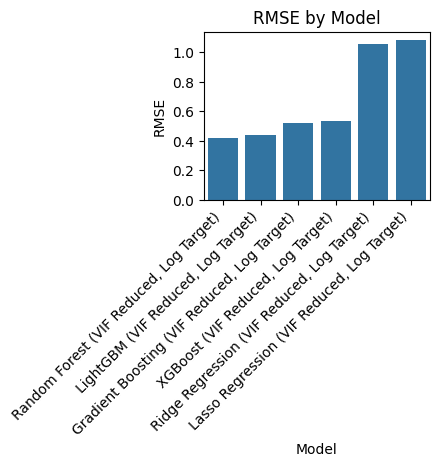

In [49]:
# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='RMSE', data=performance_df.sort_values('RMSE'))
plt.title('RMSE by Model')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Random Forest (VIF Reduced, Log Target)'),
  Text(1, 0, 'LightGBM (VIF Reduced, Log Target)'),
  Text(2, 0, 'Gradient Boosting (VIF Reduced, Log Target)'),
  Text(3, 0, 'XGBoost (VIF Reduced, Log Target)'),
  Text(4, 0, 'Ridge Regression (VIF Reduced, Log Target)'),
  Text(5, 0, 'Lasso Regression (VIF Reduced, Log Target)')])

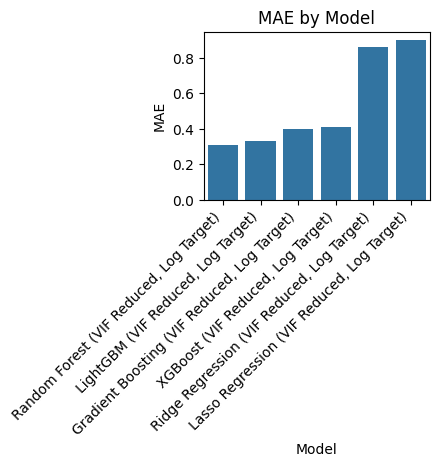

In [50]:
# MAE comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='MAE', data=performance_df.sort_values('MAE'))
plt.title('MAE by Model')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Random Forest (VIF Reduced, Log Target)'),
  Text(1, 0, 'LightGBM (VIF Reduced, Log Target)'),
  Text(2, 0, 'Gradient Boosting (VIF Reduced, Log Target)'),
  Text(3, 0, 'XGBoost (VIF Reduced, Log Target)'),
  Text(4, 0, 'Ridge Regression (VIF Reduced, Log Target)'),
  Text(5, 0, 'Lasso Regression (VIF Reduced, Log Target)')])

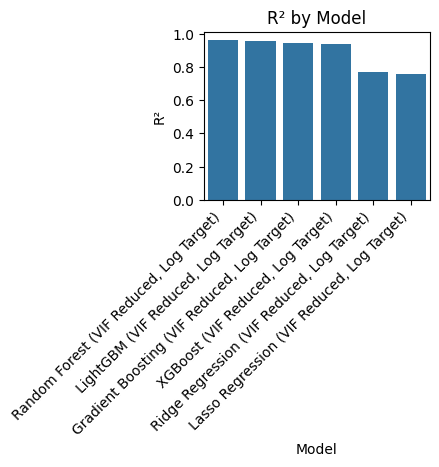

In [51]:
# R² comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='R²', data=performance_df.sort_values('R²', ascending=False))
plt.title('R² by Model')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Ridge Regression (VIF Reduced, Log Target)'),
  Text(1, 0, 'Lasso Regression (VIF Reduced, Log Target)'),
  Text(2, 0, 'LightGBM (VIF Reduced, Log Target)'),
  Text(3, 0, 'XGBoost (VIF Reduced, Log Target)'),
  Text(4, 0, 'Random Forest (VIF Reduced, Log Target)'),
  Text(5, 0, 'Gradient Boosting (VIF Reduced, Log Target)')])

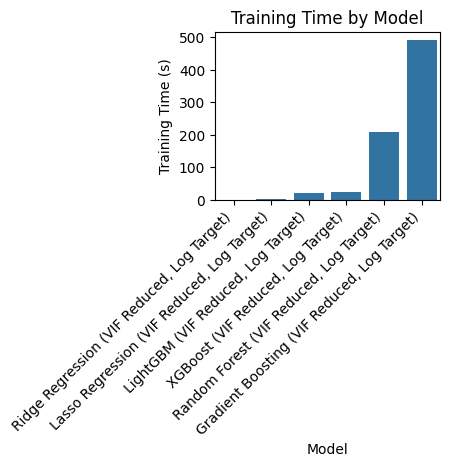

In [52]:
# Training time comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Training Time (s)', data=performance_df.sort_values('Training Time (s)'))
plt.title('Training Time by Model')
plt.xticks(rotation=45, ha='right')

Hyperparameter Tuning

In [55]:
gc.collect()

0

In [58]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [59]:
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

In [60]:
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [61]:
random_search_rf.fit(X_train_clean, y_train_clean) #take 35 minutes

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

best_estimator_:
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=10,
                      random_state=42)

In [64]:
best_rf_model = RandomForestRegressor(
    max_depth=5,
    max_features='sqrt',
    min_samples_split=10,
    random_state=42
)
best_rf_model.fit(X_train_clean, y_train_log)
rf_result = evaluate_model(
    best_rf_model,
    X_train_clean,
    X_val_clean,
    y_train_log,
    y_val_log,
    "Tuned Random Forest (VIF Reduced, Log Target)"
)
model_results['Tuned Random Forest (VIF Reduced, Log Target)'] = rf_result


Tuned Random Forest (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 1.0828
MAE: 0.8708
R²: 0.7608
Training Time: 93.85 seconds
Inference Time: 2.06 seconds


In [63]:
gc.collect()

122

In [70]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
lgb_model = LGBMRegressor(random_state=42)
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_lgb.fit(X_train_clean, y_train_clean) #take 25 minutes
print("Best Hyperparameters for LightGBM:", random_search_lgb.best_params_)

In [72]:
best_lgb_model = LGBMRegressor(
    subsample=0.8,
    num_leaves=70,
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.1,
    colsample_bytree=0.8,
    random_state=42
)
best_lgb_model.fit(X_train_clean, y_train_clean)
lgb_result = evaluate_model(
    best_lgb_model,
    X_train_clean,
    X_val_clean,
    y_train_clean,
    y_val_clean,
    "Tuned LightGBM (VIF Reduced, Log Target)"
)
model_results["Tuned LightGBM (VIF Reduced, Log Target)"] = lgb_result


Tuned LightGBM (VIF Reduced, Log Target) Evaluation on Validation Set:
RMSE: 0.3227
MAE: 0.2335
R²: 0.9788
Training Time: 43.88 seconds
Inference Time: 10.46 seconds


In [76]:
label_encoder = LabelEncoder()
label_encoder.fit(X_train['family'])
X_test['family'] = label_encoder.transform(X_test['family'])

In [77]:
X_train_clean = pd.get_dummies(X_train, drop_first=True)
X_val_clean = pd.get_dummies(X_val, drop_first=True)
X_test_clean = pd.get_dummies(X_test, drop_first=True)

In [79]:
Q1 = X_train['transactions'].quantile(0.25)
Q3 = X_train['transactions'].quantile(0.75)
IQR = Q3 - Q1
min_limit = Q1 - 1.5 * IQR
max_limit = Q3 + 1.5 * IQR
X_train['transactions'] = X_train['transactions'].clip(lower=min_limit, upper=max_limit)
X_test['transactions'] = X_test['transactions'].clip(lower=min_limit, upper=max_limit)

In [80]:
X_train['transactions'] = X_train['transactions'].clip(lower=min_limit, upper=max_limit)
X_test['transactions'] = X_test['transactions'].clip(lower=min_limit, upper=max_limit)

In [81]:
X_test_clean = X_test_clean.drop(columns=['year', 'month', 'day', 'quarter', 'days_in_month', 'day_of_year', 'week_of_year'])

In [82]:
y_test_clean = np.log1p(y_test)

In [88]:
X_test_clean = X_test_clean.fillna(X_test_clean.mean())
X_test_clean = X_test_clean.apply(lambda col: col.fillna(col.mode()[0]) if col.dtypes == 'object' else col)

In [89]:
X_test_clean = X_test_clean.dropna()

In [93]:
y_test_clean = y_test_clean.fillna(y_test_clean.mean())

In [95]:
y_test_clean = y_test_clean.replace([np.inf, -np.inf], np.nan).fillna(0)
y_test_pred = np.clip(y_test_pred, -1e10, 1e10)

In [96]:
y_test_pred = best_lgb_model.predict(X_test_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_test_pred))
mae = mean_absolute_error(y_test_clean, y_test_pred)
r2 = r2_score(y_test_clean, y_test_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 0.32425450225689467
MAE: 0.23386234535730055
R²: 0.9785504402149149


In [98]:
y_train_clean_df = pd.DataFrame(y_train_clean)
y_test_clean_df = pd.DataFrame(y_test_clean)
y_train_clean_df.to_parquet('y_train_clean.parquet', index=False)
y_test_clean_df.to_parquet('y_test_clean.parquet', index=False)

In [102]:
X_val_clean.to_parquet('X_val_clean.parquet', index=False)
y_val_clean_df = y_val_clean.to_frame()
y_val_clean_df.to_parquet('y_val_clean.parquet', index=False)

In [100]:
import joblib
joblib.dump(best_lgb_model, 'final_lgbm_model.pkl')

['final_lgbm_model.pkl']